<a href="https://colab.research.google.com/github/jorobledo/blcourse_test/blob/main/BLcourse5/colab/01_simple_gp_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Initialize Colab
!git clone git@github.com:jorobledo/bayesian_learning_course.git
%cd blcourse_test/BLcourse5/colab/

# Notation
$\newcommand{\ve}[1]{\mathit{\boldsymbol{#1}}}$
$\newcommand{\ma}[1]{\mathbf{#1}}$
$\newcommand{\pred}[1]{\widehat{#1}}$
$\newcommand{\cov}{\mathrm{cov}}$

Vector $\ve a\in\mathbb R^n$ or $\mathbb R^{n\times 1}$, so "column" vector.
Matrix $\ma A\in\mathbb R^{n\times m}$. Design matrix with input vectors $\ve
x_i\in\mathbb R^D$: $\ma X = [\ldots, \ve x_i, \ldots]^\top \in\mathbb
R^{N\times D}$.

We use 1D data, so in fact $\ma X \in\mathbb R^{N\times 1}$ is a vector, but
we still denote the collection of all $\ve x_i = x_i\in\mathbb R$ points with
$\ma X$ to keep the notation consistent with the slides.

# Imports, helpers, setup

In [3]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
%matplotlib inline

import math
from collections import defaultdict
from pprint import pprint

import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib import is_interactive


def extract_model_params(model, raw=False) -> dict:
    """Helper to convert model.named_parameters() to dict.

    With raw=True, use
        foo.bar.raw_param
    else
        foo.bar.param

    See https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/Hyperparameters.html#Raw-vs-Actual-Parameters
    """
    if raw:
        return dict(
            (p_name, p_val.item())
            for p_name, p_val in model.named_parameters()
        )
    else:
        out = dict()
        # p_name = 'covar_module.base_kernel.raw_lengthscale'. Access
        # model.covar_module.base_kernel.lengthscale (w/o the raw_)
        for p_name, p_val in model.named_parameters():
            # Yes, eval() hack. Sorry.
            p_name = p_name.replace(".raw_", ".")
            p_val = eval(f"model.{p_name}")
            out[p_name] = p_val.item()
        return out


def plot_samples(ax, X_pred, samples, label=None, **kwds):
    plot_kwds = dict(color="tab:green", alpha=0.3)
    plot_kwds.update(kwds)

    if label is None:
        ax.plot(X_pred, samples.T, **plot_kwds)
    else:
        ax.plot(X_pred, samples[0, :], **plot_kwds, label=label)
        ax.plot(X_pred, samples[1:, :].T, **plot_kwds, label="_")


# Default float32 results in slightly noisy prior samples. Less so with
# float64. We get a warning with both
#   .../lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40:
#       NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
# but the noise is smaller w/ float64. Reason must be that the `sample()`
# method [1] calls `rsample()` [2] which performs a Cholesky decomposition of
# the covariance matrix. The default in
# np.random.default_rng().multivariate_normal() is method="svd", which is
# slower but seemingly a bit more stable.
#
# [1] https://docs.gpytorch.ai/en/stable/distributions.html#gpytorch.distributions.MultivariateNormal.sample
# [2] https://docs.gpytorch.ai/en/stable/distributions.html#gpytorch.distributions.MultivariateNormal.rsample
torch.set_default_dtype(torch.float64)

torch.manual_seed(123)

# Generate toy 1D data

Here we generate noisy 1D data `X_train`, `y_train` as well as an extended
x-axis `X_pred` which we use later for prediction also outside of the data
range (extrapolation). The data has a constant offset `const` which we use to
test learning a GP mean function $m(\ve x)$. We create a gap in the data to
show how the model uncertainty will behave there.

X_train.shape=torch.Size([69])
y_train.shape=torch.Size([69])
X_pred.shape=torch.Size([200])


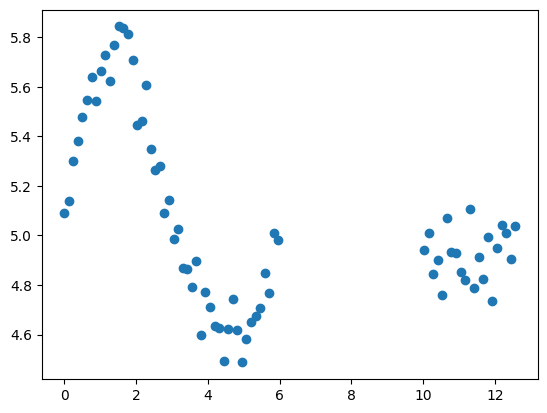

In [5]:
def generate_data(x, gaps=[[1, 3]], const=5):
    y = torch.sin(x) * torch.exp(-0.2 * x) + torch.randn(x.shape) * 0.1 + const
    msk = torch.tensor([True] * len(x))
    if gaps is not None:
        for g in gaps:
            msk = msk & ~((x > g[0]) & (x < g[1]))
    return x[msk], y[msk]


x = torch.linspace(0, 4 * math.pi, 100)
X_train, y_train = generate_data(x, gaps=[[6, 10]])
X_pred = torch.linspace(
    X_train[0] - 2, X_train[-1] + 2, 200, requires_grad=False
)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_pred.shape=}")

plt.scatter(X_train, y_train, marker="o", color="tab:blue")

# Define GP model

We define the simplest possible textbook GP model using a Gaussian
likelihood. The kernel is the squared exponential kernel with a scaling
factor.

$$\kappa(\ve x_i, \ve x_j) = \sigma_f\,\exp\left(-\frac{\lVert\ve x_i - \ve x_j\rVert_2^2}{2\,\ell^2}\right)$$

This makes two hyper params, namely the length scale $\ell$ and the scaling
$\sigma_f$. The latter is implemented by wrapping the `RBFKernel` with
`ScaleKernel`.

In addition, we define a constant mean via `ConstantMean`. Finally we have
the likelihood noise $\sigma_n^2$. So in total we have 4 hyper params.

* $\ell$ = `model.covar_module.base_kernel.lengthscale`
* $\sigma_n^2$ = `model.likelihood.noise_covar.noise`
* $\sigma_f$ = `model.covar_module.outputscale`
* $m(\ve x) = c$ = `model.mean_module.constant`

In [6]:
class ExactGPModel(gpytorch.models.ExactGP):
    """API:

    model.forward()             prior                   f_pred
    model()                     posterior               f_pred

    likelihood(model.forward()) prior with noise        y_pred
    likelihood(model())         posterior with noise    y_pred
    """

    def __init__(self, X_train, y_train, likelihood):
        super().__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [7]:
# Inspect the model
print(model)

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)


In [8]:
# Default start hyper params
pprint(extract_model_params(model, raw=False))

{'covar_module.base_kernel.lengthscale': 0.6931471805599453,
 'covar_module.outputscale': 0.6931471805599453,
 'likelihood.noise_covar.noise': 0.6932471805599453,
 'mean_module.constant': 0.0}


In [9]:
# Set new start hyper params
model.mean_module.constant = 3.0
model.covar_module.base_kernel.lengthscale = 1.0
model.covar_module.outputscale = 1.0
model.likelihood.noise_covar.noise = 0.1

pprint(extract_model_params(model, raw=False))

{'covar_module.base_kernel.lengthscale': 1.0,
 'covar_module.outputscale': 1.0,
 'likelihood.noise_covar.noise': 0.1,
 'mean_module.constant': 3.0}


# Sample from the GP prior

We sample a number of functions $f_j, j=1,\ldots,M$ from the GP prior and
evaluate them at all $\ma X$ = `X_pred` points, of which we have $N'=200$. So
we effectively generate samples from $p(\pred{\ve y}|\ma X) = \mathcal N(\ve
c, \ma K)$. Each sampled vector $\pred{\ve y}\in\mathbb R^{N'}$ and the
covariance (kernel) matrix is $\ma K\in\mathbb R^{N'\times N'}$.

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


pri_f=MultivariateNormal(loc: torch.Size([200]))
pri_f.mean.shape=torch.Size([200])
pri_f.covariance_matrix.shape=torch.Size([200, 200])
f_samples.shape=torch.Size([10, 200])


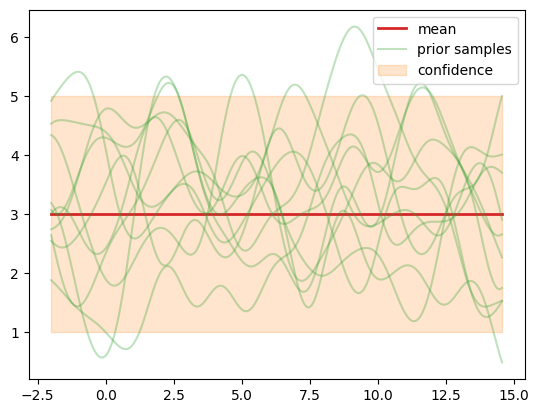

In [10]:
model.eval()
likelihood.eval()

with torch.no_grad():
    # Prior
    M = 10
    pri_f = model.forward(X_pred)
    f_mean = pri_f.mean
    f_std = pri_f.stddev
    f_samples = pri_f.sample(sample_shape=torch.Size((M,)))
    print(f"{pri_f=}")
    print(f"{pri_f.mean.shape=}")
    print(f"{pri_f.covariance_matrix.shape=}")
    print(f"{f_samples.shape=}")
    fig, ax = plt.subplots()
    ax.plot(X_pred, f_mean, color="tab:red", label="mean", lw=2)
    plot_samples(ax, X_pred, f_samples, label="prior samples")
    ax.fill_between(
        X_pred,
        f_mean - 2 * f_std,
        f_mean + 2 * f_std,
        color="tab:orange",
        alpha=0.2,
        label="confidence",
    )
    ax.legend()

Let's investigate the samples more closely. A constant mean $\ve m(\ma X) =
\ve c$ does *not* mean that each sampled vector $\pred{\ve y}$'s mean is
equal to $c$. Instead, we have that at each $\ve x_i$, the mean of
*all* sampled functions is the same, so $\frac{1}{M}\sum_{j=1}^M f_j(\ve x_i)
\approx c$ and for $M\rightarrow\infty$ it will be exactly $c$.


In [11]:
# Look at the first 20 x points from M=10 samples
print(f"{f_samples.shape=}")
print(f"{f_samples.mean(axis=0)[:20]=}")
print(f"{f_samples.mean(axis=0).mean()=}")
print(f"{f_samples.mean(axis=0).std()=}")

f_samples.shape=torch.Size([10, 200])
f_samples.mean(axis=0)[:20]=tensor([3.2870, 3.2644, 3.2399, 3.2143, 3.1882, 3.1621, 3.1368, 3.1128, 3.0905,
        3.0703, 3.0522, 3.0365, 3.0230, 3.0114, 3.0016, 2.9931, 2.9856, 2.9788,
        2.9723, 2.9658])
f_samples.mean(axis=0).mean()=tensor(3.2061)
f_samples.mean(axis=0).std()=tensor(0.2459)


In [12]:
# Take more samples, the means should get closer to c
f_samples = pri_f.sample(sample_shape=torch.Size((M * 200,)))
print(f"{f_samples.shape=}")
print(f"{f_samples.mean(axis=0)[:20]=}")
print(f"{f_samples.mean(axis=0).mean()=}")
print(f"{f_samples.mean(axis=0).std()=}")

f_samples.shape=torch.Size([2000, 200])
f_samples.mean(axis=0)[:20]=tensor([2.9535, 2.9550, 2.9565, 2.9580, 2.9594, 2.9609, 2.9624, 2.9639, 2.9655,
        2.9672, 2.9691, 2.9711, 2.9733, 2.9756, 2.9782, 2.9810, 2.9840, 2.9872,
        2.9904, 2.9937])
f_samples.mean(axis=0).mean()=tensor(2.9894)
f_samples.mean(axis=0).std()=tensor(0.0158)


# Fit GP to data: optimize hyper params

In each step of the optimizer, we condition on the training data (e.g. do
Bayesian inference) to calculate the weight posterior for the current values
of the hyper params.

We use a simplistic PyTorch-style hand written train loop without convergence
control, so make sure to use enough `n_iter` and eyeball-check that the loss
is converged :-)

Observe how all hyper params converge. In particular, note that the constant
mean $m(\ve x)=c$ converges to the `const` value in `generate_data()`.

iter 10/200, loss=-0.257
iter 20/200, loss=-0.601
iter 30/200, loss=-0.681
iter 40/200, loss=-0.677
iter 50/200, loss=-0.705
iter 60/200, loss=-0.722
iter 70/200, loss=-0.738
iter 80/200, loss=-0.738
iter 90/200, loss=-0.739
iter 100/200, loss=-0.739
iter 110/200, loss=-0.739
iter 120/200, loss=-0.739
iter 130/200, loss=-0.739
iter 140/200, loss=-0.739
iter 150/200, loss=-0.739
iter 160/200, loss=-0.739
iter 170/200, loss=-0.739
iter 180/200, loss=-0.739
iter 190/200, loss=-0.739
iter 200/200, loss=-0.739


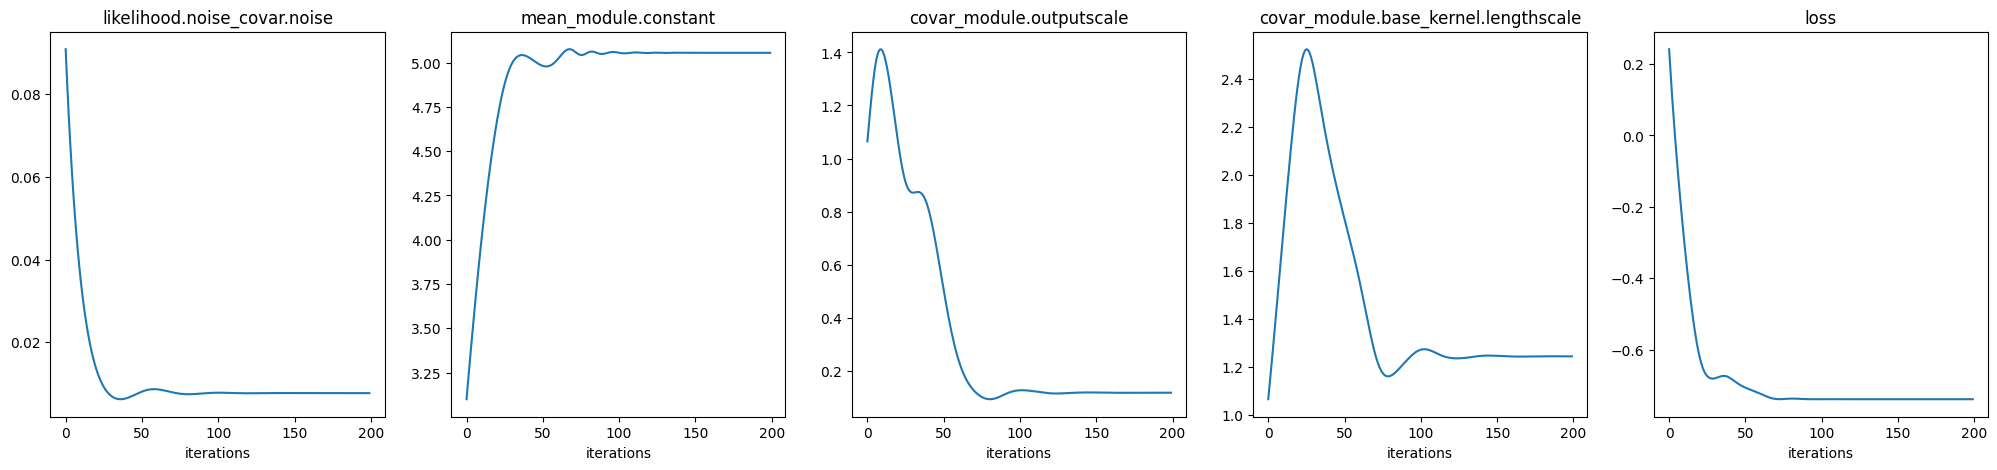

In [13]:
# Train mode
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_func = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 200
history = defaultdict(list)
for ii in range(n_iter):
    optimizer.zero_grad()
    loss = -loss_func(model(X_train), y_train)
    loss.backward()
    optimizer.step()
    if (ii + 1) % 10 == 0:
        print(f"iter {ii+1}/{n_iter}, {loss=:.3f}")
    for p_name, p_val in extract_model_params(model).items():
        history[p_name].append(p_val)
    history["loss"].append(loss.item())

# Plot hyper params and loss (neg. log marginal likelihood) convergence
ncols = len(history)
fig, axs = plt.subplots(ncols=ncols, nrows=1, figsize=(ncols * 5, 5))
for ax, (p_name, p_lst) in zip(axs, history.items()):
    ax.plot(p_lst)
    ax.set_title(p_name)
    ax.set_xlabel("iterations")

# Run prediction

We show "noiseless" (left: $\sigma = \sqrt{\mathrm{diag}(\ma\Sigma)}$) vs.
"noisy" (right: $\sigma = \sqrt{\mathrm{diag}(\ma\Sigma + \sigma_n^2\,\ma
I_N)}$) predictions, where $\ma\Sigma\equiv\cov(\ve f_*)$ is the posterior
predictive covariance matrix from R&W 2006 eq. 2.24 with $\ma K = K(X,X)$,
$\ma K'=K(X_*, X)$ and $\ma K''=K(X_*, X_*)$, so

$$\ma\Sigma = \ma K'' - \ma K'\,(\ma K+\sigma_n^2\,\ma I)^{-1}\,\ma K'^\top$$

See
https://elcorto.github.io/gp_playground/content/gp_pred_comp/notebook_plot.html
for details.

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


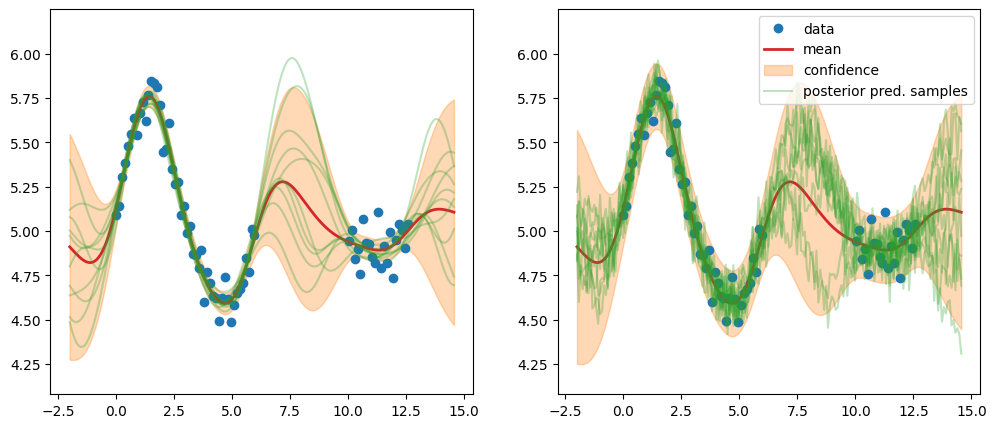

In [14]:
# Evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad():
    post_pred_f = model(X_pred)
    post_pred_y = likelihood(model(X_pred))

    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    for ii, (ax, post_pred) in enumerate(zip(axs, [post_pred_f, post_pred_y])):
        yf_mean = post_pred.mean
        yf_samples = post_pred.sample(sample_shape=torch.Size((10,)))

        ##lower, upper = post_pred.confidence_region()
        yf_std = post_pred.stddev
        lower = yf_mean - 2 * yf_std
        upper = yf_mean + 2 * yf_std
        ax.plot(
            X_train.numpy(),
            y_train.numpy(),
            "o",
            label="data",
            color="tab:blue",
        )
        ax.plot(
            X_pred.numpy(),
            yf_mean.numpy(),
            label="mean",
            color="tab:red",
            lw=2,
        )
        ax.fill_between(
            X_pred.numpy(),
            lower.numpy(),
            upper.numpy(),
            label="confidence",
            color="tab:orange",
            alpha=0.3,
        )
        y_min = y_train.min()
        y_max = y_train.max()
        y_span = y_max - y_min
        ax.set_ylim([y_min - 0.3 * y_span, y_max + 0.3 * y_span])
        plot_samples(ax, X_pred, yf_samples, label="posterior pred. samples")
        if ii == 1:
            ax.legend()

# When running as script
if not is_interactive():
    plt.show()